In [1]:
import pandas as pd
import numpy as np
from random import randint, choice
import seaborn as sns
from scipy.sparse import csgraph
import random
from sklearn.cluster import SpectralClustering
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
def DTWDistance(s1, s2, data_format="pandas"):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            if data_format=="pandas":
                dist= (s1.iloc[i]-s2.iloc[j])**2
            else:
                dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [3]:
def put_weights_measure(graph, time_series, method=0, data_format="pandas"):
    new_graph = graph
    for node in range(graph.shape[0]):
        for other_node in range(graph.shape[0]):
            if node == other_node:
                pass
            elif graph[node][other_node] == 0:
                pass
            else:
                if data_format =="pandas":
                    ts1 = time_series.iloc[:, node]
                    ts2 = time_series.iloc[:,other_node]
                else:
                    ts1 = time_series[node]
                    ts2 = time_series[other_node]
                if method == 0:
                    try:
                        new_graph[node][other_node] = 1 /DTWDistance(ts1, ts2, data_format="pandas")
                    except:
                        print(ts1, ts2)
                        break
                elif method == 1:
                    new_graph[node][other_node] = np.exp(-DTWDistance(ts1, ts2, data_format="pandas"))
                else:
                    pass
    return new_graph

In [4]:
def make_consensus_matrix(clustering_matrix):
    M = np.zeros([clustering_matrix.shape[1], clustering_matrix.shape[1]])
    for i in range(clustering_matrix.shape[1]):
        for j in range(clustering_matrix.shape[1]):
            i_j = 0
            for k in range(clustering_matrix.shape[0]):
                if clustering_matrix[k,i] == clustering_matrix[k, j]:
                    i_j+=1
                else:
                    pass
            M[i, j] = i_j / clustering_matrix.shape[0]
    return M

In [5]:
def consensus(graph, time_series, n_clusters, method=0, data_format="pandas", show=False):
#     n_days = time_series.shape[0]//24
#     n_days = time_series.shape[1]
    n_nodes = graph.shape[0]
    clustering_matrix = np.array([])
    if data_format=="pandas":
        n_days = time_series.shape[0]//24
        for i in range(n_days):
            if show == True:
                if i % 30 == 0:
                    print(i)
            if method == 1:
                time_labels = time_clustering(time_series.iloc[i*24:24*(i+1), 1:])
                day_graph = put_weights(time_labels, graph)
            else:
                day_graph = put_weights_measure(graph, time_series.iloc[i*24:24*(i+1), 1:], method=0, data_format="pandas")

    #         laplacian = csgraph.laplacian(day_graph)
            graph_clustering = SpectralClustering(n_clusters=n_clusters,
                random_state=0, affinity='precomputed').fit(day_graph)

            labels = graph_clustering.labels_
    #         print(labels)
            clustering_matrix =  np.append(clustering_matrix, labels)
    if data_format=="numpy":
        n_days = time_series.shape[1]
        for day in range(n_days):
    #         print(time_labels)
            if method == 0:
                time_labels = time_clustering(time_series[:,day,:])
                day_graph = put_weights(time_labels, graph)
            else:
                day_graph = put_weights_measure(graph, time_series[:,day,:], method=0)

    #         laplacian = csgraph.laplacian(day_graph)
            graph_clustering = SpectralClustering(n_clusters=n_clusters,
                random_state=0, affinity='precomputed').fit(day_graph)

            labels = graph_clustering.labels_
    #         print(labels)
            clustering_matrix =  np.append(clustering_matrix, labels)
    
    clustering_matrix = clustering_matrix.reshape(n_days, n_nodes)
#     clustering_matrix = clustering_matrix.reshape(n_nodes, n_days)
#     print(n_days, "dff", n_nodes)
#     print(clustering_matrix)
    clustering_matrix.resize(n_days, n_nodes)
    
    consensus_matrix = make_consensus_matrix(clustering_matrix)
    
    return consensus_matrix

In [6]:
data = pd.read_csv("Static_data/solar_layouts_ECMWF.csv")
nodes = pd.read_csv("Static_data/network_nodes.csv")
edges = pd.read_csv("Static_data/network_edges.csv")

In [7]:
print(nodes.shape, edges.shape)
display(nodes.head(10))
edges.head(10)

(1494, 6) (2156, 7)


,ID,name,country,voltage,latitude,longitude
0,1,P-1,POR,380,42.094674,-8.113982
1,2,P-2,POR,380,41.587435,-8.326462
2,3,P-3,POR,380,41.585994,-6.722728
3,4,P-4,POR,380,41.597684,-6.342848
4,5,P-5,POR,380,41.373957,-7.350949
5,6,P-6,POR,380,41.227376,-8.314878
6,7,P-7,POR,380,41.242598,-7.803650
7,8,P-9,POR,380,41.295851,-7.057333
8,9,P-10,POR,380,40.816342,-7.367185
9,10,P-11,POR,380,40.713238,-8.336832


,fromNode,toNode,X,Y,numLines,limit,length
0,344,559,0.012030,83.125520,1,1260.0,51.227041
1,344,561,0.015980,62.578223,1,1490.0,34.002397
2,344,336,0.013212,75.687824,2,0.0,25.467094
3,344,566,0.013770,72.621641,1,1320.0,34.755553
4,344,356,0.021120,47.348485,1,0.0,61.628358
5,344,327,0.004580,218.341463,2,0.0,28.879081
6,344,350,0.039130,25.555651,2,0.0,45.419774
7,345,362,0.150760,6.633059,1,0.0,91.720871
8,345,330,0.089520,11.170688,1,0.0,59.079134
9,345,353,0.074400,13.440860,1,0.0,48.300438


In [8]:
solar = pd.read_csv("Static_data/solar_layouts_COSMO.csv")

In [9]:
solar_time = pd.read_csv("Nodal_TS/solar_signal_COSMO.csv")

In [10]:
solar_time.head()

,Time,1,2,3,4,5,6,7,8,9,...,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514
0,2012-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
import matplotlib.pyplot as plt

In [12]:
# for i in range(20):
#     d1 = np.array(solar_time["1"][i*24:24*(i+1)])
#     d2 = np.array(solar_time["1"][(i+1)*24:(i+2)*24])
#     DTWDistance(d1, d2)
#     print(DTWDistance(d1, d2,data_format='numpy'))
#     plt.plot(d1)
# plt.show()

In [13]:
solar_time.head()

,Time,1,2,3,4,5,6,7,8,9,...,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514
0,2012-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
description = pd.read_csv("Static_data/generator_info.csv")

In [15]:
description.head()

,ID,name,country,origin,latitude,longitude,status,primaryfuel,secondaryfuel,capacity,lincost,cyclecost,minuptime,mindowntime,minonlinecapacity
0,2069,Almaraz Nuclear Power Plant Spain,Spain,162,39.807053,-5.698600,No Data in GEO,Nuclear,Unknown,1957.0,12.464831,587100.00,24,24,391.40
1,2142,Aramon Oil Power Plant France,France,486,43.880078,4.654770,Operating Fully,Fuel Oil,Unknown,1400.0,123.113578,77000.00,2,4,560.00
2,2154,Argentat Hydroelectric Generating Station,France,457,45.104000,1.954000,No Data in GEO,Hydro,Unknown,47.5,6.699853,204.25,0,0,4.75
3,2175,Asco Nuclear Power Plant Spain,Spain,124,41.200841,0.567942,No Data in GEO,Nuclear,Unknown,2060.0,12.476609,618000.00,24,24,412.00
4,2300,Belleville Nuclear Power Plant France,France,357,47.511658,2.874155,Operating Fully,Nuclear,Unknown,2726.0,12.551846,817800.00,24,24,545.20


In [16]:
import networkx as nx
RE_netwrok = nx.Graph()

In [17]:
for node in nodes.ID:
    RE_netwrok.add_node(node)
for i, row in edges.iterrows():
    RE_netwrok.add_edge(int(row.fromNode), int(row.toNode)) 

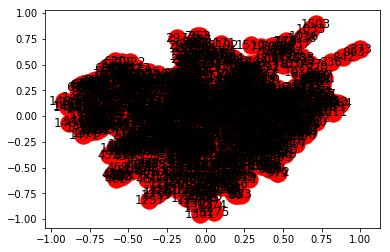

In [69]:
nx.draw_networkx(RE_netwrok)

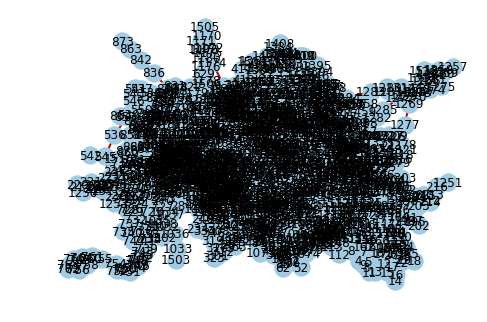

In [15]:
import matplotlib.pyplot as plt

pos=nx.spring_layout(RE_netwrok)   #G is my graph

nx.draw(RE_netwrok,pos,node_color='#A0CBE2',edge_color='#BB0000',width=2,edge_cmap=plt.cm.Blues,with_labels=True)
#plt.show()
# plt.savefig("graph.png", dpi=500, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format=None,transparent=False, bbox_inches=None, pad_inches=0.1)
plt.savefig("graph.pdf")


In [26]:
adj = nx.to_numpy_array(RE_netwrok)

cons20 = consensus(adj, solar_time.iloc[:480], 10, method=0, data_format="pandas", show=True)

0


In [23]:
solar_time.iloc[:1440].tail()

,Time,1,2,3,4,5,6,7,8,9,...,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514
1435,2012-02-29 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1436,2012-02-29 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1437,2012-02-29 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1438,2012-02-29 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1439,2012-02-29 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
24 * 20

480

In [39]:
cons20

In [38]:
np.savetxt('test.txt', cons20, delimiter=',') 

In [41]:
np.savetxt('sorted.txt', cons20, delimiter=',') 

In [ ]:
1+1